## Prepare Dataset

In [9]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io
from torchvision import transforms
import torch
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
import numpy as np

seed = 42
torch.manual_seed(seed)

In [10]:
def x_pos_flap(x_pos):
    return int(120 - x_pos)

def y_pos_flap(y_pos): 
    return int(400 - y_pos)

In [11]:
class FootDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, label_transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)

        x1 = self.annotations.iloc[index, 1]
        y1 = self.annotations.iloc[index, 2]
        x2 = self.annotations.iloc[index, 3]
        y2 = self.annotations.iloc[index, 4]

        if self.label_transform:
            if self.label_transform == "x":
                x1 = x_pos_flap(x1)
                x2 = x_pos_flap(x2) 
            elif self.label_transform == "y":
                y1 = x_pos_flap(y1)
                y2 = x_pos_flap(y2) 
            elif self.label_transform == "xy":
                x1 = x_pos_flap(x1)
                y1 = x_pos_flap(y1)
                x2 = x_pos_flap(x2) 
                y2 = x_pos_flap(y2)

        y_label = torch.tensor([x1 / 120.0, y1 / 400.0, x2 / 120.0, y2 / 400.0])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [12]:
# Hyperparameters
num_classes = 4
batch_size = 32
learning_rate = 1e-4
num_epochs = 500

In [13]:
csv_file = './train/annotation.csv'
root_dir = './train/images/'

# Non Flap
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = FootDataset(csv_file, root_dir, transform)

# X Flap
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.RandomHorizontalFlip(p=1), # flap with axix x
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
xflap_train_dataset = FootDataset(csv_file, root_dir, transform, 'x')

# Y Flap
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.RandomVerticalFlip(p=1), # flap with axix y
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
yflap_train_dataset = FootDataset(csv_file, root_dir, transform, 'y')

# X, Y Flap
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.RandomHorizontalFlip(p=1), # flap with axix x
    transforms.RandomVerticalFlip(p=1), # flap with axix y
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
xyflap_train_dataset = FootDataset(csv_file, root_dir, transform, 'xy')

In [15]:
csv_file = './train_20210106/annotation.csv'
root_dir = './train_20210106/images/'

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = FootDataset(csv_file, root_dir, transform)

In [16]:
concated_train_dataset = ConcatDataset([train_dataset,
                                        xflap_train_dataset,
                                        yflap_train_dataset,
                                        xyflap_train_dataset])

train_loader = DataLoader(dataset=concated_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

concated_train_dataset.__getitem__(3000)

(tensor([[[2.1804, 2.1804, 2.2147,  ..., 2.2318, 2.2147, 2.2147],
          [2.1804, 2.1804, 2.2147,  ..., 2.2318, 2.2147, 2.2147],
          [2.1633, 2.1804, 2.2147,  ..., 2.2318, 2.2147, 2.2147],
          ...,
          [2.1633, 2.1804, 2.2147,  ..., 2.2318, 2.2147, 2.2147],
          [2.1804, 2.1804, 2.2147,  ..., 2.2318, 2.2147, 2.2147],
          [2.1804, 2.1804, 2.2147,  ..., 2.2318, 2.2147, 2.2147]],
 
         [[2.3410, 2.3585, 2.3936,  ..., 2.3585, 2.3060, 2.2885],
          [2.3410, 2.3585, 2.3936,  ..., 2.3585, 2.3060, 2.2885],
          [2.3410, 2.3585, 2.3936,  ..., 2.3585, 2.3060, 2.2885],
          ...,
          [2.3410, 2.3585, 2.3936,  ..., 2.3585, 2.3060, 2.2885],
          [2.3410, 2.3585, 2.3936,  ..., 2.3585, 2.3060, 2.2885],
          [2.3410, 2.3585, 2.3936,  ..., 2.3585, 2.3060, 2.2885]],
 
         [[2.5180, 2.5354, 2.5703,  ..., 2.5529, 2.5180, 2.5006],
          [2.5180, 2.5354, 2.5703,  ..., 2.5529, 2.5180, 2.5006],
          [2.5180, 2.5354, 2.5703,  ...,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'HxW: 996x299')

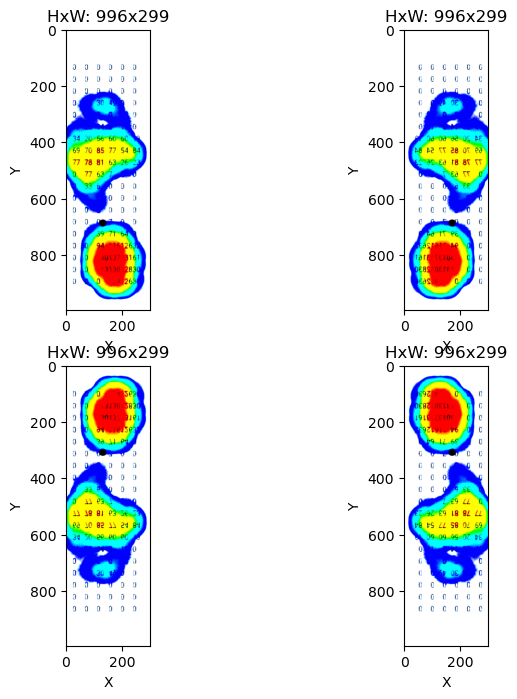

In [17]:
# Assuming you have already imported necessary libraries and defined concated_train_dataset and other functions like x_pos_flap and y_pos_flap

df = pd.read_csv(csv_file)

# Get the 1st image
image1 = concated_train_dataset[0][0].permute(1, 2, 0).numpy()
image2 = concated_train_dataset[1000][0].permute(1, 2, 0).numpy()
image3 = concated_train_dataset[2000][0].permute(1, 2, 0).numpy()
image4 = concated_train_dataset[3000][0].permute(1, 2, 0).numpy()

# Assuming you have points for each image
# points1 = [(df['x1'].iloc[0] / 120 * 299, df['y1'].iloc[0] / 400 * 229), (df['x2'].iloc[0] / 120 * 299, df['y2'].iloc[0] / 400 * 229)]  
# points2 = [(x_pos_flap(df['x1'].iloc[0]) / 120 * 299, df['y1'].iloc[0] / 400 * 229), (x_pos_flap(df['x2'].iloc[0]) / 120 * 299, df['y2'].iloc[0] / 400 * 229)]  
# points3 = [(df['x1'].iloc[0] / 120 * 299, y_pos_flap(df['y1'].iloc[0]) / 400 * 229), (df['x2'].iloc[0] / 120 * 299, y_pos_flap(df['y2'].iloc[0]) / 400 * 229)]  
# points4 = [(x_pos_flap(df['x1'].iloc[0]) / 120 * 299, y_pos_flap(df['y1'].iloc[0]) / 400 * 229), (x_pos_flap(df['x2'].iloc[0]) / 120 * 299, y_pos_flap(df['y2'].iloc[0]) / 400 * 229)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# Plot image1
axes[0, 0].imshow(image1)
#axes[0, 0].scatter([p[0] for p in points1], [p[1] for p in points1], color='red', s=10)
axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title(f'HxW: {image1.shape[0]}x{image1.shape[1]}')

# Plot image2
axes[0, 1].imshow(image2)
#axes[0, 1].scatter([p[0] for p in points2], [p[1] for p in points2], color='red', s=10)
axes[0, 1].set_xlabel('X')
axes[0, 1].set_ylabel('Y')
axes[0, 1].set_title(f'HxW: {image2.shape[0]}x{image2.shape[1]}')

# Plot image3
axes[1, 0].imshow(image3)
#axes[1, 0].scatter([p[0] for p in points3], [p[1] for p in points3], color='red', s=10)
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_title(f'HxW: {image3.shape[0]}x{image3.shape[1]}')

# Plot image4
axes[1, 1].imshow(image4)
#axes[1, 1].scatter([p[0] for p in points4], [p[1] for p in points4], color='red', s=10)
axes[1, 1].set_xlabel('X')
axes[1, 1].set_ylabel('Y')
axes[1, 1].set_title(f'HxW: {image4.shape[0]}x{image4.shape[1]}')

In [18]:
concated_train_dataset[0][1]

tensor([0.4583, 0.3400, 0.6250, 0.9575], dtype=torch.float64)

## Build Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from tqdm import tqdm

In [20]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
model = torchvision.models.inception_v3(pretrained=False, aux_logits=False)
print(model)

/home/m416-3090/anaconda3/envs/ViT-fine-tune/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/m416-3090/anaconda3/envs/ViT-fine-tune/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/m416-3090/anaconda3/envs/ViT-fine-tune/lib/python3.9/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:
model.fc = nn.Sequential(
    nn.Linear(2048, 10),
    nn.ReLU(),
    nn.Linear(10, 4),
)
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [25]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training loop

In [26]:
train_losses = []
val_losses = []
validation_losses = []
best_val_loss = float('inf')  # Initialize with a very large value
best_model_path = './model/best_inception-v3_model.pth'

patience = 50  # Number of epochs to wait before stopping if the validation loss doesn't improve
early_stopping_counter = 0

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        losses = []

        model.train()
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores.float(), targets.float())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        losses.append(loss)

    train_loss = sum(losses) / len(losses)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        for data_val, targets_val in val_loader:
            data_val = data_val.to(device=device)
            targets_val = targets_val.to(device=device)

            val_scores = model(data_val)
            val_loss = criterion(val_scores.float(), targets_val.float())

            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    validation_losses.append(avg_val_loss)

    if epoch <= 20:
        early_stopping_counter = 0

    # Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.7f}, Val Loss: {avg_val_loss:.7f}, Learning Rate: {optimizer.param_groups[0]['lr']:.7f} \n")

100%|██████████| 125/125 [00:42<00:00,  2.97it/s]
/home/m416-3090/anaconda3/envs/ViT-fine-tune/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/500], Train Loss: 0.0854377, Val Loss: 0.0875038, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [2/500], Train Loss: 0.0640017, Val Loss: 0.0673485, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.05it/s]


Epoch [3/500], Train Loss: 0.0293867, Val Loss: 0.0525422, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [4/500], Train Loss: 0.0215864, Val Loss: 0.0424520, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [5/500], Train Loss: 0.0114891, Val Loss: 0.0354505, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [6/500], Train Loss: 0.0073323, Val Loss: 0.0304392, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [7/500], Train Loss: 0.0064787, Val Loss: 0.0267388, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [8/500], Train Loss: 0.0066354, Val Loss: 0.0237133, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [9/500], Train Loss: 0.0041550, Val Loss: 0.0213822, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [10/500], Train Loss: 0.0038927, Val Loss: 0.0194864, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [11/500], Train Loss: 0.0034193, Val Loss: 0.0180261, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [12/500], Train Loss: 0.0036169, Val Loss: 0.0167146, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [13/500], Train Loss: 0.0030571, Val Loss: 0.0156124, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [14/500], Train Loss: 0.0036792, Val Loss: 0.0146768, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [15/500], Train Loss: 0.0033073, Val Loss: 0.0139785, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [16/500], Train Loss: 0.0045030, Val Loss: 0.0134056, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [17/500], Train Loss: 0.0037261, Val Loss: 0.0127675, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [18/500], Train Loss: 0.0037791, Val Loss: 0.0121737, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [19/500], Train Loss: 0.0025307, Val Loss: 0.0116392, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [20/500], Train Loss: 0.0027194, Val Loss: 0.0111938, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [21/500], Train Loss: 0.0041022, Val Loss: 0.0107266, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [22/500], Train Loss: 0.0022470, Val Loss: 0.0103568, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [23/500], Train Loss: 0.0024174, Val Loss: 0.0100288, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [24/500], Train Loss: 0.0031054, Val Loss: 0.0096815, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [25/500], Train Loss: 0.0033002, Val Loss: 0.0093576, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [26/500], Train Loss: 0.0025440, Val Loss: 0.0090671, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [27/500], Train Loss: 0.0027485, Val Loss: 0.0088275, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [28/500], Train Loss: 0.0023372, Val Loss: 0.0085857, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [29/500], Train Loss: 0.0028743, Val Loss: 0.0083611, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [30/500], Train Loss: 0.0019848, Val Loss: 0.0081521, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [31/500], Train Loss: 0.0012367, Val Loss: 0.0079438, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [32/500], Train Loss: 0.0031880, Val Loss: 0.0077490, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [33/500], Train Loss: 0.0019793, Val Loss: 0.0075642, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [34/500], Train Loss: 0.0032983, Val Loss: 0.0073954, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [35/500], Train Loss: 0.0017688, Val Loss: 0.0072308, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [36/500], Train Loss: 0.0021788, Val Loss: 0.0070687, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [37/500], Train Loss: 0.0016601, Val Loss: 0.0069194, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [38/500], Train Loss: 0.0020139, Val Loss: 0.0067869, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [39/500], Train Loss: 0.0015954, Val Loss: 0.0066569, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [40/500], Train Loss: 0.0015608, Val Loss: 0.0065261, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [41/500], Train Loss: 0.0014873, Val Loss: 0.0064001, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [42/500], Train Loss: 0.0013723, Val Loss: 0.0062849, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [43/500], Train Loss: 0.0015605, Val Loss: 0.0061730, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [44/500], Train Loss: 0.0013176, Val Loss: 0.0060710, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [45/500], Train Loss: 0.0011712, Val Loss: 0.0059727, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [46/500], Train Loss: 0.0014270, Val Loss: 0.0058827, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [47/500], Train Loss: 0.0017539, Val Loss: 0.0057860, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [48/500], Train Loss: 0.0009501, Val Loss: 0.0056933, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [49/500], Train Loss: 0.0011982, Val Loss: 0.0056070, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [50/500], Train Loss: 0.0018321, Val Loss: 0.0055271, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [51/500], Train Loss: 0.0016264, Val Loss: 0.0054427, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [52/500], Train Loss: 0.0016420, Val Loss: 0.0053679, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [53/500], Train Loss: 0.0009904, Val Loss: 0.0053042, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [54/500], Train Loss: 0.0010738, Val Loss: 0.0052378, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [55/500], Train Loss: 0.0016772, Val Loss: 0.0051676, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [56/500], Train Loss: 0.0012901, Val Loss: 0.0051008, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [57/500], Train Loss: 0.0011605, Val Loss: 0.0050418, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [58/500], Train Loss: 0.0010856, Val Loss: 0.0049788, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [59/500], Train Loss: 0.0014855, Val Loss: 0.0049160, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [60/500], Train Loss: 0.0014776, Val Loss: 0.0048531, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [61/500], Train Loss: 0.0010929, Val Loss: 0.0047967, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [62/500], Train Loss: 0.0016241, Val Loss: 0.0047411, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [63/500], Train Loss: 0.0007848, Val Loss: 0.0046935, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [64/500], Train Loss: 0.0008574, Val Loss: 0.0046392, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [65/500], Train Loss: 0.0008412, Val Loss: 0.0045846, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [66/500], Train Loss: 0.0015079, Val Loss: 0.0045362, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [67/500], Train Loss: 0.0008970, Val Loss: 0.0044894, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [68/500], Train Loss: 0.0015174, Val Loss: 0.0044417, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [69/500], Train Loss: 0.0012839, Val Loss: 0.0044021, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [70/500], Train Loss: 0.0009767, Val Loss: 0.0043546, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [71/500], Train Loss: 0.0010850, Val Loss: 0.0043116, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [72/500], Train Loss: 0.0018479, Val Loss: 0.0042721, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [73/500], Train Loss: 0.0014990, Val Loss: 0.0042293, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [74/500], Train Loss: 0.0013865, Val Loss: 0.0041896, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [75/500], Train Loss: 0.0008932, Val Loss: 0.0041548, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [76/500], Train Loss: 0.0015659, Val Loss: 0.0041186, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [77/500], Train Loss: 0.0010648, Val Loss: 0.0040821, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [78/500], Train Loss: 0.0012771, Val Loss: 0.0040443, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [79/500], Train Loss: 0.0013527, Val Loss: 0.0040089, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [80/500], Train Loss: 0.0010438, Val Loss: 0.0039751, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [81/500], Train Loss: 0.0009038, Val Loss: 0.0039408, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [82/500], Train Loss: 0.0010607, Val Loss: 0.0039060, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [83/500], Train Loss: 0.0009705, Val Loss: 0.0038733, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [84/500], Train Loss: 0.0014136, Val Loss: 0.0038452, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [85/500], Train Loss: 0.0008731, Val Loss: 0.0038149, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [86/500], Train Loss: 0.0008174, Val Loss: 0.0037831, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [87/500], Train Loss: 0.0008792, Val Loss: 0.0037524, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [88/500], Train Loss: 0.0009833, Val Loss: 0.0037213, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [89/500], Train Loss: 0.0008734, Val Loss: 0.0036906, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [90/500], Train Loss: 0.0011335, Val Loss: 0.0036625, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [91/500], Train Loss: 0.0015946, Val Loss: 0.0036357, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [92/500], Train Loss: 0.0009963, Val Loss: 0.0036081, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [93/500], Train Loss: 0.0009596, Val Loss: 0.0035861, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [94/500], Train Loss: 0.0008305, Val Loss: 0.0035587, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [95/500], Train Loss: 0.0010598, Val Loss: 0.0035339, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [96/500], Train Loss: 0.0009774, Val Loss: 0.0035099, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [97/500], Train Loss: 0.0006882, Val Loss: 0.0034854, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [98/500], Train Loss: 0.0006825, Val Loss: 0.0034640, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [99/500], Train Loss: 0.0009067, Val Loss: 0.0034402, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [100/500], Train Loss: 0.0009845, Val Loss: 0.0034167, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [101/500], Train Loss: 0.0006587, Val Loss: 0.0033936, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [102/500], Train Loss: 0.0013414, Val Loss: 0.0033730, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [103/500], Train Loss: 0.0009507, Val Loss: 0.0033504, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [104/500], Train Loss: 0.0011114, Val Loss: 0.0033283, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [105/500], Train Loss: 0.0008892, Val Loss: 0.0033056, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [106/500], Train Loss: 0.0009838, Val Loss: 0.0032839, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [107/500], Train Loss: 0.0006058, Val Loss: 0.0032642, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [108/500], Train Loss: 0.0004851, Val Loss: 0.0032439, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [109/500], Train Loss: 0.0008573, Val Loss: 0.0032239, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [110/500], Train Loss: 0.0008879, Val Loss: 0.0032068, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [111/500], Train Loss: 0.0007396, Val Loss: 0.0031874, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [112/500], Train Loss: 0.0009387, Val Loss: 0.0031687, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [113/500], Train Loss: 0.0008947, Val Loss: 0.0031510, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [114/500], Train Loss: 0.0007277, Val Loss: 0.0031326, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [115/500], Train Loss: 0.0008941, Val Loss: 0.0031155, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [116/500], Train Loss: 0.0007930, Val Loss: 0.0030995, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [117/500], Train Loss: 0.0009070, Val Loss: 0.0030827, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [118/500], Train Loss: 0.0006149, Val Loss: 0.0030652, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [119/500], Train Loss: 0.0005784, Val Loss: 0.0030512, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [120/500], Train Loss: 0.0006252, Val Loss: 0.0030346, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [121/500], Train Loss: 0.0010358, Val Loss: 0.0030188, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [122/500], Train Loss: 0.0008799, Val Loss: 0.0030020, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [123/500], Train Loss: 0.0005886, Val Loss: 0.0029915, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [124/500], Train Loss: 0.0006619, Val Loss: 0.0029756, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [125/500], Train Loss: 0.0008769, Val Loss: 0.0029610, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [126/500], Train Loss: 0.0010582, Val Loss: 0.0029454, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [127/500], Train Loss: 0.0005030, Val Loss: 0.0029317, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [128/500], Train Loss: 0.0009163, Val Loss: 0.0029180, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [129/500], Train Loss: 0.0007984, Val Loss: 0.0029035, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [130/500], Train Loss: 0.0006369, Val Loss: 0.0028889, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [131/500], Train Loss: 0.0007785, Val Loss: 0.0028740, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [132/500], Train Loss: 0.0010405, Val Loss: 0.0028596, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [133/500], Train Loss: 0.0007463, Val Loss: 0.0028454, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [134/500], Train Loss: 0.0004707, Val Loss: 0.0028323, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [135/500], Train Loss: 0.0010203, Val Loss: 0.0028195, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [136/500], Train Loss: 0.0005155, Val Loss: 0.0028063, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [137/500], Train Loss: 0.0005687, Val Loss: 0.0027931, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [138/500], Train Loss: 0.0007411, Val Loss: 0.0027803, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [139/500], Train Loss: 0.0009143, Val Loss: 0.0027679, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [140/500], Train Loss: 0.0007045, Val Loss: 0.0027563, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [141/500], Train Loss: 0.0008827, Val Loss: 0.0027435, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [142/500], Train Loss: 0.0005868, Val Loss: 0.0027321, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [143/500], Train Loss: 0.0008479, Val Loss: 0.0027199, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [144/500], Train Loss: 0.0007024, Val Loss: 0.0027097, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [145/500], Train Loss: 0.0005631, Val Loss: 0.0027004, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [146/500], Train Loss: 0.0006000, Val Loss: 0.0026900, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [147/500], Train Loss: 0.0009202, Val Loss: 0.0026789, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [148/500], Train Loss: 0.0006201, Val Loss: 0.0026678, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [149/500], Train Loss: 0.0006154, Val Loss: 0.0026569, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [150/500], Train Loss: 0.0005300, Val Loss: 0.0026471, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [151/500], Train Loss: 0.0006049, Val Loss: 0.0026364, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [152/500], Train Loss: 0.0004185, Val Loss: 0.0026253, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [153/500], Train Loss: 0.0006546, Val Loss: 0.0026143, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [154/500], Train Loss: 0.0004990, Val Loss: 0.0026039, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [155/500], Train Loss: 0.0007262, Val Loss: 0.0025937, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [156/500], Train Loss: 0.0007484, Val Loss: 0.0025830, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [157/500], Train Loss: 0.0006290, Val Loss: 0.0025734, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [158/500], Train Loss: 0.0007076, Val Loss: 0.0025629, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [159/500], Train Loss: 0.0005714, Val Loss: 0.0025527, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [160/500], Train Loss: 0.0005880, Val Loss: 0.0025426, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [161/500], Train Loss: 0.0004092, Val Loss: 0.0025341, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [162/500], Train Loss: 0.0006450, Val Loss: 0.0025241, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [163/500], Train Loss: 0.0006044, Val Loss: 0.0025145, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [164/500], Train Loss: 0.0008993, Val Loss: 0.0025059, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [165/500], Train Loss: 0.0007178, Val Loss: 0.0024978, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [166/500], Train Loss: 0.0007561, Val Loss: 0.0024896, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [167/500], Train Loss: 0.0006631, Val Loss: 0.0024809, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [168/500], Train Loss: 0.0008835, Val Loss: 0.0024730, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [169/500], Train Loss: 0.0005476, Val Loss: 0.0024645, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [170/500], Train Loss: 0.0005852, Val Loss: 0.0024576, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [171/500], Train Loss: 0.0003390, Val Loss: 0.0024484, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [172/500], Train Loss: 0.0008212, Val Loss: 0.0024398, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [173/500], Train Loss: 0.0005234, Val Loss: 0.0024312, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [174/500], Train Loss: 0.0004355, Val Loss: 0.0024228, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [175/500], Train Loss: 0.0004579, Val Loss: 0.0024149, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [176/500], Train Loss: 0.0005992, Val Loss: 0.0024074, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [177/500], Train Loss: 0.0005801, Val Loss: 0.0023997, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [178/500], Train Loss: 0.0007651, Val Loss: 0.0023919, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [179/500], Train Loss: 0.0004576, Val Loss: 0.0023846, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [180/500], Train Loss: 0.0005673, Val Loss: 0.0023766, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [181/500], Train Loss: 0.0004758, Val Loss: 0.0023696, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [182/500], Train Loss: 0.0005394, Val Loss: 0.0023615, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [183/500], Train Loss: 0.0005544, Val Loss: 0.0023536, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [184/500], Train Loss: 0.0006650, Val Loss: 0.0023457, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [185/500], Train Loss: 0.0010360, Val Loss: 0.0023381, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [186/500], Train Loss: 0.0005904, Val Loss: 0.0023311, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [187/500], Train Loss: 0.0004970, Val Loss: 0.0023239, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:42<00:00,  2.97it/s]


Epoch [188/500], Train Loss: 0.0006766, Val Loss: 0.0023171, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [189/500], Train Loss: 0.0009974, Val Loss: 0.0023104, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [190/500], Train Loss: 0.0005632, Val Loss: 0.0023029, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [191/500], Train Loss: 0.0006019, Val Loss: 0.0022967, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [192/500], Train Loss: 0.0007113, Val Loss: 0.0022898, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [193/500], Train Loss: 0.0007977, Val Loss: 0.0022842, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [194/500], Train Loss: 0.0005287, Val Loss: 0.0022770, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [195/500], Train Loss: 0.0008845, Val Loss: 0.0022709, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [196/500], Train Loss: 0.0008663, Val Loss: 0.0022641, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [197/500], Train Loss: 0.0007779, Val Loss: 0.0022579, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [198/500], Train Loss: 0.0005052, Val Loss: 0.0022514, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [199/500], Train Loss: 0.0004741, Val Loss: 0.0022447, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [200/500], Train Loss: 0.0007156, Val Loss: 0.0022381, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [201/500], Train Loss: 0.0005359, Val Loss: 0.0022320, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [202/500], Train Loss: 0.0009221, Val Loss: 0.0022261, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [203/500], Train Loss: 0.0005100, Val Loss: 0.0022200, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [204/500], Train Loss: 0.0005712, Val Loss: 0.0022136, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [205/500], Train Loss: 0.0005287, Val Loss: 0.0022079, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [206/500], Train Loss: 0.0008161, Val Loss: 0.0022020, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [207/500], Train Loss: 0.0005218, Val Loss: 0.0021961, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [208/500], Train Loss: 0.0006815, Val Loss: 0.0021901, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [209/500], Train Loss: 0.0006438, Val Loss: 0.0021844, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [210/500], Train Loss: 0.0006191, Val Loss: 0.0021781, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [211/500], Train Loss: 0.0006837, Val Loss: 0.0021726, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [212/500], Train Loss: 0.0004453, Val Loss: 0.0021672, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [213/500], Train Loss: 0.0003630, Val Loss: 0.0021616, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [214/500], Train Loss: 0.0007154, Val Loss: 0.0021569, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [215/500], Train Loss: 0.0005621, Val Loss: 0.0021516, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [216/500], Train Loss: 0.0004085, Val Loss: 0.0021456, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [217/500], Train Loss: 0.0004963, Val Loss: 0.0021405, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [218/500], Train Loss: 0.0008897, Val Loss: 0.0021351, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [219/500], Train Loss: 0.0005553, Val Loss: 0.0021298, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [220/500], Train Loss: 0.0005920, Val Loss: 0.0021246, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [221/500], Train Loss: 0.0005181, Val Loss: 0.0021190, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [222/500], Train Loss: 0.0004855, Val Loss: 0.0021144, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [223/500], Train Loss: 0.0005470, Val Loss: 0.0021089, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [224/500], Train Loss: 0.0006396, Val Loss: 0.0021037, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [225/500], Train Loss: 0.0012481, Val Loss: 0.0020985, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [226/500], Train Loss: 0.0008438, Val Loss: 0.0020934, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [227/500], Train Loss: 0.0004762, Val Loss: 0.0020881, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [228/500], Train Loss: 0.0005286, Val Loss: 0.0020828, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [229/500], Train Loss: 0.0005976, Val Loss: 0.0020778, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [230/500], Train Loss: 0.0004871, Val Loss: 0.0020729, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [231/500], Train Loss: 0.0007802, Val Loss: 0.0020681, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [232/500], Train Loss: 0.0003521, Val Loss: 0.0020630, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [233/500], Train Loss: 0.0003649, Val Loss: 0.0020578, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [234/500], Train Loss: 0.0005734, Val Loss: 0.0020531, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [235/500], Train Loss: 0.0010346, Val Loss: 0.0020481, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [236/500], Train Loss: 0.0007832, Val Loss: 0.0020432, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [237/500], Train Loss: 0.0007010, Val Loss: 0.0020389, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [238/500], Train Loss: 0.0005819, Val Loss: 0.0020344, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [239/500], Train Loss: 0.0005344, Val Loss: 0.0020302, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [240/500], Train Loss: 0.0004267, Val Loss: 0.0020255, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [241/500], Train Loss: 0.0008824, Val Loss: 0.0020216, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [242/500], Train Loss: 0.0003511, Val Loss: 0.0020173, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [243/500], Train Loss: 0.0005345, Val Loss: 0.0020128, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [244/500], Train Loss: 0.0004719, Val Loss: 0.0020099, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [245/500], Train Loss: 0.0004733, Val Loss: 0.0020057, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [246/500], Train Loss: 0.0006279, Val Loss: 0.0020021, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [247/500], Train Loss: 0.0004778, Val Loss: 0.0019979, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [248/500], Train Loss: 0.0003243, Val Loss: 0.0019939, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [249/500], Train Loss: 0.0003644, Val Loss: 0.0019894, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [250/500], Train Loss: 0.0005012, Val Loss: 0.0019857, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [251/500], Train Loss: 0.0005301, Val Loss: 0.0019816, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [252/500], Train Loss: 0.0003929, Val Loss: 0.0019776, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [253/500], Train Loss: 0.0004164, Val Loss: 0.0019732, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [254/500], Train Loss: 0.0007158, Val Loss: 0.0019695, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [255/500], Train Loss: 0.0005990, Val Loss: 0.0019656, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [256/500], Train Loss: 0.0004747, Val Loss: 0.0019612, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [257/500], Train Loss: 0.0006261, Val Loss: 0.0019574, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [258/500], Train Loss: 0.0002790, Val Loss: 0.0019535, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [259/500], Train Loss: 0.0006335, Val Loss: 0.0019501, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [260/500], Train Loss: 0.0009299, Val Loss: 0.0019465, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [261/500], Train Loss: 0.0007464, Val Loss: 0.0019435, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [262/500], Train Loss: 0.0007287, Val Loss: 0.0019397, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [263/500], Train Loss: 0.0005836, Val Loss: 0.0019357, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [264/500], Train Loss: 0.0006005, Val Loss: 0.0019317, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:42<00:00,  2.98it/s]


Epoch [265/500], Train Loss: 0.0007379, Val Loss: 0.0019275, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [266/500], Train Loss: 0.0003277, Val Loss: 0.0019237, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [267/500], Train Loss: 0.0006368, Val Loss: 0.0019200, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [268/500], Train Loss: 0.0005230, Val Loss: 0.0019164, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [269/500], Train Loss: 0.0006295, Val Loss: 0.0019126, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [270/500], Train Loss: 0.0008224, Val Loss: 0.0019095, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [271/500], Train Loss: 0.0003290, Val Loss: 0.0019058, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [272/500], Train Loss: 0.0004488, Val Loss: 0.0019020, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [273/500], Train Loss: 0.0003824, Val Loss: 0.0018986, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [274/500], Train Loss: 0.0006039, Val Loss: 0.0018949, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [275/500], Train Loss: 0.0004111, Val Loss: 0.0018913, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [276/500], Train Loss: 0.0004233, Val Loss: 0.0018879, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [277/500], Train Loss: 0.0004181, Val Loss: 0.0018843, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [278/500], Train Loss: 0.0005424, Val Loss: 0.0018808, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [279/500], Train Loss: 0.0004750, Val Loss: 0.0018772, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [280/500], Train Loss: 0.0005308, Val Loss: 0.0018736, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [281/500], Train Loss: 0.0004596, Val Loss: 0.0018700, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:42<00:00,  2.96it/s]


Epoch [282/500], Train Loss: 0.0004559, Val Loss: 0.0018665, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:42<00:00,  2.95it/s]


Epoch [283/500], Train Loss: 0.0006829, Val Loss: 0.0018627, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [284/500], Train Loss: 0.0004022, Val Loss: 0.0018594, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [285/500], Train Loss: 0.0005651, Val Loss: 0.0018565, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [286/500], Train Loss: 0.0008516, Val Loss: 0.0018530, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [287/500], Train Loss: 0.0005198, Val Loss: 0.0018498, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [288/500], Train Loss: 0.0004429, Val Loss: 0.0018466, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [289/500], Train Loss: 0.0004003, Val Loss: 0.0018432, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [290/500], Train Loss: 0.0003775, Val Loss: 0.0018399, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:42<00:00,  2.97it/s]


Epoch [291/500], Train Loss: 0.0002969, Val Loss: 0.0018366, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [292/500], Train Loss: 0.0008440, Val Loss: 0.0018334, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [293/500], Train Loss: 0.0005948, Val Loss: 0.0018301, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [294/500], Train Loss: 0.0005571, Val Loss: 0.0018269, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [295/500], Train Loss: 0.0005562, Val Loss: 0.0018240, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [296/500], Train Loss: 0.0004688, Val Loss: 0.0018211, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [297/500], Train Loss: 0.0004805, Val Loss: 0.0018178, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [298/500], Train Loss: 0.0004959, Val Loss: 0.0018147, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [299/500], Train Loss: 0.0005114, Val Loss: 0.0018116, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [300/500], Train Loss: 0.0005614, Val Loss: 0.0018086, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [301/500], Train Loss: 0.0003988, Val Loss: 0.0018060, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [302/500], Train Loss: 0.0003753, Val Loss: 0.0018029, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [303/500], Train Loss: 0.0004035, Val Loss: 0.0017998, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [304/500], Train Loss: 0.0003268, Val Loss: 0.0017968, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [305/500], Train Loss: 0.0005060, Val Loss: 0.0017936, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [306/500], Train Loss: 0.0005182, Val Loss: 0.0017907, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [307/500], Train Loss: 0.0002711, Val Loss: 0.0017877, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [308/500], Train Loss: 0.0003373, Val Loss: 0.0017850, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [309/500], Train Loss: 0.0003448, Val Loss: 0.0017823, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [310/500], Train Loss: 0.0009574, Val Loss: 0.0017797, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [311/500], Train Loss: 0.0003664, Val Loss: 0.0017766, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [312/500], Train Loss: 0.0004115, Val Loss: 0.0017742, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [313/500], Train Loss: 0.0008582, Val Loss: 0.0017719, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [314/500], Train Loss: 0.0005802, Val Loss: 0.0017693, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [315/500], Train Loss: 0.0004709, Val Loss: 0.0017664, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [316/500], Train Loss: 0.0004679, Val Loss: 0.0017635, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [317/500], Train Loss: 0.0005619, Val Loss: 0.0017608, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [318/500], Train Loss: 0.0005198, Val Loss: 0.0017582, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [319/500], Train Loss: 0.0003990, Val Loss: 0.0017554, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [320/500], Train Loss: 0.0003950, Val Loss: 0.0017529, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [321/500], Train Loss: 0.0004914, Val Loss: 0.0017509, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [322/500], Train Loss: 0.0003331, Val Loss: 0.0017483, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [323/500], Train Loss: 0.0004910, Val Loss: 0.0017462, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [324/500], Train Loss: 0.0004314, Val Loss: 0.0017436, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [325/500], Train Loss: 0.0003120, Val Loss: 0.0017411, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [326/500], Train Loss: 0.0003565, Val Loss: 0.0017387, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [327/500], Train Loss: 0.0008860, Val Loss: 0.0017373, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [328/500], Train Loss: 0.0007871, Val Loss: 0.0017346, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [329/500], Train Loss: 0.0006643, Val Loss: 0.0017323, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [330/500], Train Loss: 0.0004748, Val Loss: 0.0017296, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [331/500], Train Loss: 0.0004303, Val Loss: 0.0017271, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [332/500], Train Loss: 0.0005383, Val Loss: 0.0017249, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [333/500], Train Loss: 0.0005066, Val Loss: 0.0017227, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [334/500], Train Loss: 0.0004733, Val Loss: 0.0017203, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:42<00:00,  2.97it/s]


Epoch [335/500], Train Loss: 0.0005384, Val Loss: 0.0017179, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [336/500], Train Loss: 0.0004982, Val Loss: 0.0017157, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [337/500], Train Loss: 0.0003823, Val Loss: 0.0017138, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [338/500], Train Loss: 0.0004518, Val Loss: 0.0017117, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [339/500], Train Loss: 0.0005373, Val Loss: 0.0017097, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [340/500], Train Loss: 0.0003313, Val Loss: 0.0017074, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [341/500], Train Loss: 0.0003515, Val Loss: 0.0017050, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [342/500], Train Loss: 0.0003985, Val Loss: 0.0017029, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [343/500], Train Loss: 0.0004039, Val Loss: 0.0017005, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [344/500], Train Loss: 0.0003722, Val Loss: 0.0016983, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [345/500], Train Loss: 0.0003356, Val Loss: 0.0016960, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [346/500], Train Loss: 0.0006662, Val Loss: 0.0016938, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [347/500], Train Loss: 0.0003338, Val Loss: 0.0016914, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [348/500], Train Loss: 0.0005484, Val Loss: 0.0016893, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [349/500], Train Loss: 0.0006026, Val Loss: 0.0016870, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [350/500], Train Loss: 0.0004447, Val Loss: 0.0016848, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [351/500], Train Loss: 0.0006933, Val Loss: 0.0016826, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [352/500], Train Loss: 0.0004053, Val Loss: 0.0016806, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [353/500], Train Loss: 0.0004043, Val Loss: 0.0016785, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [354/500], Train Loss: 0.0004444, Val Loss: 0.0016763, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [355/500], Train Loss: 0.0003643, Val Loss: 0.0016742, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [356/500], Train Loss: 0.0004047, Val Loss: 0.0016722, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [357/500], Train Loss: 0.0003686, Val Loss: 0.0016698, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [358/500], Train Loss: 0.0006032, Val Loss: 0.0016679, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [359/500], Train Loss: 0.0005532, Val Loss: 0.0016658, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [360/500], Train Loss: 0.0005777, Val Loss: 0.0016636, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [361/500], Train Loss: 0.0004004, Val Loss: 0.0016618, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [362/500], Train Loss: 0.0003728, Val Loss: 0.0016596, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [363/500], Train Loss: 0.0004523, Val Loss: 0.0016576, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [364/500], Train Loss: 0.0003251, Val Loss: 0.0016553, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [365/500], Train Loss: 0.0005213, Val Loss: 0.0016535, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [366/500], Train Loss: 0.0002785, Val Loss: 0.0016514, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [367/500], Train Loss: 0.0003002, Val Loss: 0.0016494, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [368/500], Train Loss: 0.0006905, Val Loss: 0.0016478, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [369/500], Train Loss: 0.0003429, Val Loss: 0.0016458, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [370/500], Train Loss: 0.0004869, Val Loss: 0.0016436, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [371/500], Train Loss: 0.0006233, Val Loss: 0.0016416, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [372/500], Train Loss: 0.0008834, Val Loss: 0.0016395, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [373/500], Train Loss: 0.0005867, Val Loss: 0.0016375, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [374/500], Train Loss: 0.0004514, Val Loss: 0.0016355, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [375/500], Train Loss: 0.0004800, Val Loss: 0.0016334, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [376/500], Train Loss: 0.0002618, Val Loss: 0.0016316, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [377/500], Train Loss: 0.0003683, Val Loss: 0.0016299, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [378/500], Train Loss: 0.0005108, Val Loss: 0.0016282, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [379/500], Train Loss: 0.0004455, Val Loss: 0.0016262, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [380/500], Train Loss: 0.0004708, Val Loss: 0.0016246, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [381/500], Train Loss: 0.0006410, Val Loss: 0.0016226, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [382/500], Train Loss: 0.0004072, Val Loss: 0.0016208, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [383/500], Train Loss: 0.0003418, Val Loss: 0.0016190, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [384/500], Train Loss: 0.0004089, Val Loss: 0.0016173, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [385/500], Train Loss: 0.0004666, Val Loss: 0.0016155, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [386/500], Train Loss: 0.0003908, Val Loss: 0.0016136, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [387/500], Train Loss: 0.0003846, Val Loss: 0.0016118, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [388/500], Train Loss: 0.0003308, Val Loss: 0.0016102, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [389/500], Train Loss: 0.0002410, Val Loss: 0.0016092, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [390/500], Train Loss: 0.0004706, Val Loss: 0.0016074, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [391/500], Train Loss: 0.0006370, Val Loss: 0.0016057, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [392/500], Train Loss: 0.0004418, Val Loss: 0.0016037, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [393/500], Train Loss: 0.0003007, Val Loss: 0.0016021, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [394/500], Train Loss: 0.0003762, Val Loss: 0.0016002, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [395/500], Train Loss: 0.0002426, Val Loss: 0.0015984, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [396/500], Train Loss: 0.0004026, Val Loss: 0.0015964, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [397/500], Train Loss: 0.0005897, Val Loss: 0.0015947, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [398/500], Train Loss: 0.0004412, Val Loss: 0.0015930, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [399/500], Train Loss: 0.0004375, Val Loss: 0.0015914, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [400/500], Train Loss: 0.0006825, Val Loss: 0.0015897, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [401/500], Train Loss: 0.0005450, Val Loss: 0.0015879, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [402/500], Train Loss: 0.0007510, Val Loss: 0.0015861, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [403/500], Train Loss: 0.0002871, Val Loss: 0.0015844, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [404/500], Train Loss: 0.0009881, Val Loss: 0.0015828, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [405/500], Train Loss: 0.0002942, Val Loss: 0.0015812, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [406/500], Train Loss: 0.0002709, Val Loss: 0.0015795, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [407/500], Train Loss: 0.0003751, Val Loss: 0.0015778, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [408/500], Train Loss: 0.0002775, Val Loss: 0.0015762, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [409/500], Train Loss: 0.0003378, Val Loss: 0.0015745, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [410/500], Train Loss: 0.0007615, Val Loss: 0.0015728, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [411/500], Train Loss: 0.0004302, Val Loss: 0.0015711, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [412/500], Train Loss: 0.0003141, Val Loss: 0.0015693, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [413/500], Train Loss: 0.0004116, Val Loss: 0.0015677, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [414/500], Train Loss: 0.0003927, Val Loss: 0.0015663, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [415/500], Train Loss: 0.0003645, Val Loss: 0.0015647, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [416/500], Train Loss: 0.0003307, Val Loss: 0.0015631, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [417/500], Train Loss: 0.0002987, Val Loss: 0.0015614, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [418/500], Train Loss: 0.0003352, Val Loss: 0.0015599, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [419/500], Train Loss: 0.0002447, Val Loss: 0.0015585, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [420/500], Train Loss: 0.0004164, Val Loss: 0.0015569, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [421/500], Train Loss: 0.0004771, Val Loss: 0.0015554, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [422/500], Train Loss: 0.0003052, Val Loss: 0.0015540, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [423/500], Train Loss: 0.0003329, Val Loss: 0.0015524, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [424/500], Train Loss: 0.0005077, Val Loss: 0.0015510, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [425/500], Train Loss: 0.0003165, Val Loss: 0.0015496, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [426/500], Train Loss: 0.0004543, Val Loss: 0.0015482, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [427/500], Train Loss: 0.0004881, Val Loss: 0.0015469, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [428/500], Train Loss: 0.0005945, Val Loss: 0.0015456, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [429/500], Train Loss: 0.0003467, Val Loss: 0.0015446, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [430/500], Train Loss: 0.0003999, Val Loss: 0.0015431, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [431/500], Train Loss: 0.0004725, Val Loss: 0.0015423, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [432/500], Train Loss: 0.0004730, Val Loss: 0.0015407, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [433/500], Train Loss: 0.0002576, Val Loss: 0.0015392, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [434/500], Train Loss: 0.0003894, Val Loss: 0.0015379, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [435/500], Train Loss: 0.0003239, Val Loss: 0.0015363, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [436/500], Train Loss: 0.0002960, Val Loss: 0.0015348, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [437/500], Train Loss: 0.0004533, Val Loss: 0.0015331, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [438/500], Train Loss: 0.0004342, Val Loss: 0.0015317, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [439/500], Train Loss: 0.0005027, Val Loss: 0.0015303, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [440/500], Train Loss: 0.0003871, Val Loss: 0.0015292, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [441/500], Train Loss: 0.0004914, Val Loss: 0.0015278, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [442/500], Train Loss: 0.0007578, Val Loss: 0.0015264, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [443/500], Train Loss: 0.0003290, Val Loss: 0.0015249, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [444/500], Train Loss: 0.0004144, Val Loss: 0.0015237, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [445/500], Train Loss: 0.0003875, Val Loss: 0.0015225, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [446/500], Train Loss: 0.0002709, Val Loss: 0.0015209, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [447/500], Train Loss: 0.0003218, Val Loss: 0.0015197, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [448/500], Train Loss: 0.0004917, Val Loss: 0.0015184, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [449/500], Train Loss: 0.0003541, Val Loss: 0.0015169, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [450/500], Train Loss: 0.0003694, Val Loss: 0.0015156, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [451/500], Train Loss: 0.0004487, Val Loss: 0.0015145, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [452/500], Train Loss: 0.0003359, Val Loss: 0.0015133, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [453/500], Train Loss: 0.0004504, Val Loss: 0.0015122, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [454/500], Train Loss: 0.0002953, Val Loss: 0.0015110, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [455/500], Train Loss: 0.0003441, Val Loss: 0.0015096, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [456/500], Train Loss: 0.0006001, Val Loss: 0.0015082, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [457/500], Train Loss: 0.0004341, Val Loss: 0.0015068, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [458/500], Train Loss: 0.0006629, Val Loss: 0.0015054, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [459/500], Train Loss: 0.0004013, Val Loss: 0.0015041, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [460/500], Train Loss: 0.0001581, Val Loss: 0.0015027, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [461/500], Train Loss: 0.0003538, Val Loss: 0.0015015, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [462/500], Train Loss: 0.0005148, Val Loss: 0.0015003, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [463/500], Train Loss: 0.0004376, Val Loss: 0.0014990, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [464/500], Train Loss: 0.0003609, Val Loss: 0.0014977, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [465/500], Train Loss: 0.0005003, Val Loss: 0.0014967, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [466/500], Train Loss: 0.0005035, Val Loss: 0.0014957, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [467/500], Train Loss: 0.0003047, Val Loss: 0.0014944, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [468/500], Train Loss: 0.0006801, Val Loss: 0.0014931, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [469/500], Train Loss: 0.0004202, Val Loss: 0.0014919, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [470/500], Train Loss: 0.0002858, Val Loss: 0.0014906, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [471/500], Train Loss: 0.0002767, Val Loss: 0.0014892, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [472/500], Train Loss: 0.0004604, Val Loss: 0.0014879, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [473/500], Train Loss: 0.0005863, Val Loss: 0.0014865, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch [474/500], Train Loss: 0.0002871, Val Loss: 0.0014853, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [475/500], Train Loss: 0.0004856, Val Loss: 0.0014840, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [476/500], Train Loss: 0.0003713, Val Loss: 0.0014830, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [477/500], Train Loss: 0.0004086, Val Loss: 0.0014820, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [478/500], Train Loss: 0.0002750, Val Loss: 0.0014811, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [479/500], Train Loss: 0.0004242, Val Loss: 0.0014799, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [480/500], Train Loss: 0.0003679, Val Loss: 0.0014788, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [481/500], Train Loss: 0.0004269, Val Loss: 0.0014776, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [482/500], Train Loss: 0.0007207, Val Loss: 0.0014767, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [483/500], Train Loss: 0.0005236, Val Loss: 0.0014755, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [484/500], Train Loss: 0.0004130, Val Loss: 0.0014743, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [485/500], Train Loss: 0.0003029, Val Loss: 0.0014732, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [486/500], Train Loss: 0.0002927, Val Loss: 0.0014720, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [487/500], Train Loss: 0.0002962, Val Loss: 0.0014708, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [488/500], Train Loss: 0.0003808, Val Loss: 0.0014696, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [489/500], Train Loss: 0.0003466, Val Loss: 0.0014684, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [490/500], Train Loss: 0.0002477, Val Loss: 0.0014672, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [491/500], Train Loss: 0.0003328, Val Loss: 0.0014660, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [492/500], Train Loss: 0.0004795, Val Loss: 0.0014649, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch [493/500], Train Loss: 0.0003937, Val Loss: 0.0014637, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  2.99it/s]


Epoch [494/500], Train Loss: 0.0003589, Val Loss: 0.0014626, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [495/500], Train Loss: 0.0003253, Val Loss: 0.0014616, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


Epoch [496/500], Train Loss: 0.0004684, Val Loss: 0.0014604, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [497/500], Train Loss: 0.0004356, Val Loss: 0.0014593, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.00it/s]


Epoch [498/500], Train Loss: 0.0004881, Val Loss: 0.0014585, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [499/500], Train Loss: 0.0002611, Val Loss: 0.0014574, Learning Rate: 0.0001000 



100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch [500/500], Train Loss: 0.0002793, Val Loss: 0.0014564, Learning Rate: 0.0001000 



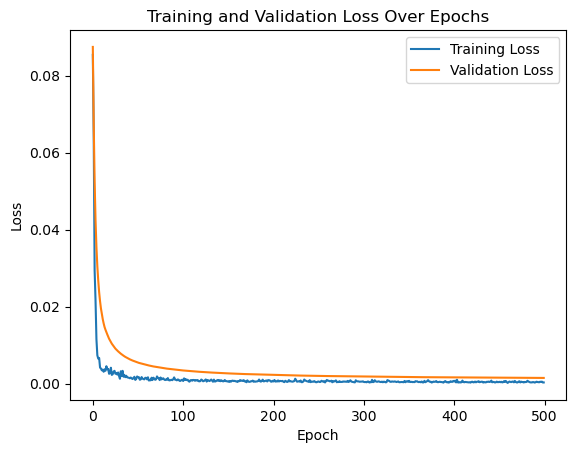

In [28]:
train_losses_values = [tensor.item() for tensor in train_losses]

# Plot the unsmoothed losses
plt.plot(train_losses_values, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [29]:
model = torchvision.models.inception_v3(pretrained=False, aux_logits=False)
model.fc = nn.Sequential(
    nn.Linear(2048, 10),
    nn.ReLU(),
    nn.Linear(10, 4),
)
#best_model_path = './model/best_inception-v3_model_rank10.pth'
best_model = model
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [30]:
def get_result(loader, model):
    scores_list = []
    val_losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            scores_list.append(scores)
            loss = criterion(scores, y)
            val_losses.append(loss.item())

    model.train()

    return scores_list, val_losses

In [31]:
scores, val_losses = get_result(val_loader, best_model)
print(f"{len(scores)} samples. \n {scores}")

424 samples. 
 [tensor([[0.4586, 0.2520, 0.2951, 0.9533]], device='cuda:0'), tensor([[0.4655, 0.3574, 0.2687, 0.9344]], device='cuda:0'), tensor([[0.4580, 0.2613, 0.7050, 0.9476]], device='cuda:0'), tensor([[0.4348, 0.3545, 0.2488, 0.9566]], device='cuda:0'), tensor([[0.4232, 0.2935, 0.6779, 0.9588]], device='cuda:0'), tensor([[0.4747, 0.2778, 0.6513, 0.9535]], device='cuda:0'), tensor([[0.4658, 0.2915, 0.2886, 0.9464]], device='cuda:0'), tensor([[0.4643, 0.2968, 0.6234, 0.9592]], device='cuda:0'), tensor([[0.4669, 0.3101, 0.2547, 0.9458]], device='cuda:0'), tensor([[0.5002, 0.3784, 0.2394, 0.9579]], device='cuda:0'), tensor([[0.4387, 0.3662, 0.5821, 0.9127]], device='cuda:0'), tensor([[0.4562, 0.3401, 0.3168, 0.9582]], device='cuda:0'), tensor([[0.4466, 0.3199, 0.6496, 0.9214]], device='cuda:0'), tensor([[0.5714, 0.3576, 0.6507, 0.9566]], device='cuda:0'), tensor([[0.4453, 0.2809, 0.6027, 0.9541]], device='cuda:0'), tensor([[0.5161, 0.2892, 0.3634, 0.9229]], device='cuda:0'), tensor([

In [32]:
scores

[tensor([[0.4586, 0.2520, 0.2951, 0.9533]], device='cuda:0'),
 tensor([[0.4655, 0.3574, 0.2687, 0.9344]], device='cuda:0'),
 tensor([[0.4580, 0.2613, 0.7050, 0.9476]], device='cuda:0'),
 tensor([[0.4348, 0.3545, 0.2488, 0.9566]], device='cuda:0'),
 tensor([[0.4232, 0.2935, 0.6779, 0.9588]], device='cuda:0'),
 tensor([[0.4747, 0.2778, 0.6513, 0.9535]], device='cuda:0'),
 tensor([[0.4658, 0.2915, 0.2886, 0.9464]], device='cuda:0'),
 tensor([[0.4643, 0.2968, 0.6234, 0.9592]], device='cuda:0'),
 tensor([[0.4669, 0.3101, 0.2547, 0.9458]], device='cuda:0'),
 tensor([[0.5002, 0.3784, 0.2394, 0.9579]], device='cuda:0'),
 tensor([[0.4387, 0.3662, 0.5821, 0.9127]], device='cuda:0'),
 tensor([[0.4562, 0.3401, 0.3168, 0.9582]], device='cuda:0'),
 tensor([[0.4466, 0.3199, 0.6496, 0.9214]], device='cuda:0'),
 tensor([[0.5714, 0.3576, 0.6507, 0.9566]], device='cuda:0'),
 tensor([[0.4453, 0.2809, 0.6027, 0.9541]], device='cuda:0'),
 tensor([[0.5161, 0.2892, 0.3634, 0.9229]], device='cuda:0'),
 tensor(

In [33]:
result = [{
         'x1': min(round(tensor[0][0].item() * 120), 120), 
         'y1': min(round(tensor[0][1].item() * 400), 400), 
         'x2': min(round(tensor[0][2].item() * 120), 120),
         'y2': min(round(tensor[0][3].item()* 400), 400)} 
        for tensor in scores]

In [34]:
df_pred = pd.DataFrame(result)
df_pred

,x1,y1,x2,y2
0,55,101,35,381
1,56,143,32,374
2,55,105,85,379
3,52,142,30,383
4,51,117,81,384
...,...,...,...,...
419,60,126,28,370
420,50,142,74,381
421,57,104,27,384
422,59,134,28,384


In [35]:
df_true = pd.read_csv("./train_20210106/annotation.csv")
df_image = pd.DataFrame()
df_image['images'] = df_true['images']
df_true = df_true.drop(columns=["images"])
df_true

,x1,y1,x2,y2
0,56,119,82,383
1,57,132,37,378
2,61,175,81,384
3,53,179,32,381
4,50,120,81,383
...,...,...,...,...
419,63,158,46,381
420,53,157,76,376
421,49,154,33,375
422,64,149,76,381


In [36]:
def distance_error(df_true, df_pred):
    d1_list = []
    d2_list = []
    d_list = []
    samples = len(df_true)
    for i in range(samples):
        x2 = df_true["x1"].iloc[i]
        x1 = df_pred["x1"].iloc[i]
        y2 = df_true["y1"].iloc[i]
        y1 = df_pred["y1"].iloc[i]
        d1 = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        d1_list.append(d1)

        x2 = df_true["x2"].iloc[i]
        x1 = df_pred["x2"].iloc[i]
        y2 = df_true["y2"].iloc[i]
        y1 = df_pred["y2"].iloc[i]
        d2 = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        d2_list.append(d2)

        d = d1 + d2
        d_list.append(d)

    return f"d1_error: {sum(d1_list) / samples}\nd2_error: {sum(d2_list) / samples}\nd_error: {sum(d_list) / samples}"
    

In [37]:
print(distance_error(df_true, df_pred)) # true, pred

d1_error: 18.106850267426637
d2_error: 28.87617808751608
d_error: 46.983028354942746


In [38]:
csv_file = './submission.csv'
root_dir = './test/images/'

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = FootDataset(csv_file, root_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [39]:
scores, _ = get_result(test_loader, best_model)
scores

[tensor([[0.4962, 0.3314, 0.6593, 0.9459]], device='cuda:0'),
 tensor([[0.4429, 0.3564, 0.2104, 0.9503]], device='cuda:0'),
 tensor([[0.4823, 0.3589, 0.6568, 0.9504]], device='cuda:0'),
 tensor([[0.4584, 0.3387, 0.2392, 0.9374]], device='cuda:0'),
 tensor([[0.5018, 0.3818, 0.5702, 0.9206]], device='cuda:0'),
 tensor([[0.4851, 0.3822, 0.2874, 0.9191]], device='cuda:0'),
 tensor([[0.5723, 0.3392, 0.6456, 0.9051]], device='cuda:0'),
 tensor([[0.4776, 0.3625, 0.2977, 0.9147]], device='cuda:0'),
 tensor([[0.4007, 0.2931, 0.6210, 0.9107]], device='cuda:0'),
 tensor([[0.5458, 0.3041, 0.2733, 0.9502]], device='cuda:0'),
 tensor([[0.4923, 0.3723, 0.6333, 0.9396]], device='cuda:0'),
 tensor([[0.4124, 0.3833, 0.2713, 0.9387]], device='cuda:0'),
 tensor([[0.5207, 0.2995, 0.6686, 0.9533]], device='cuda:0'),
 tensor([[0.4893, 0.3064, 0.2708, 0.9563]], device='cuda:0'),
 tensor([[0.5484, 0.3446, 0.6374, 0.9562]], device='cuda:0'),
 tensor([[0.4658, 0.3216, 0.1846, 0.9590]], device='cuda:0'),
 tensor(

In [40]:
result = [{
         'x1': min(round(tensor[0][0].item() * 120), 120), 
         'y1': min(round(tensor[0][1].item() * 400), 400), 
         'x2': min(round(tensor[0][2].item() * 120), 120),
         'y2': min(round(tensor[0][3].item()* 400), 400)} 
        for tensor in scores]

In [41]:
df_result = pd.DataFrame(result)
df_result

,x1,y1,x2,y2
0,60,133,79,378
1,53,143,25,380
2,58,144,79,380
3,55,135,29,375
4,60,153,68,368
...,...,...,...,...
995,60,120,39,364
996,56,133,77,382
997,61,135,30,383
998,61,120,77,382


In [42]:
df_submission = pd.read_csv(csv_file)
df_submission['x1'] = df_result['x1']
df_submission['y1'] = df_result['y1']
df_submission['x2'] = df_result['x2']
df_submission['y2'] = df_result['y2']
df_submission

,images,x1,y1,x2,y2
0,image_0001.png,60,133,79,378
1,image_0002.png,53,143,25,380
2,image_0003.png,58,144,79,380
3,image_0004.png,55,135,29,375
4,image_0005.png,60,153,68,368
...,...,...,...,...,...
995,image_0996.png,60,120,39,364
996,image_0997.png,56,133,77,382
997,image_0998.png,61,135,30,383
998,image_0999.png,61,120,77,382


In [43]:
df_submission.to_csv('./submission.csv', index=False)

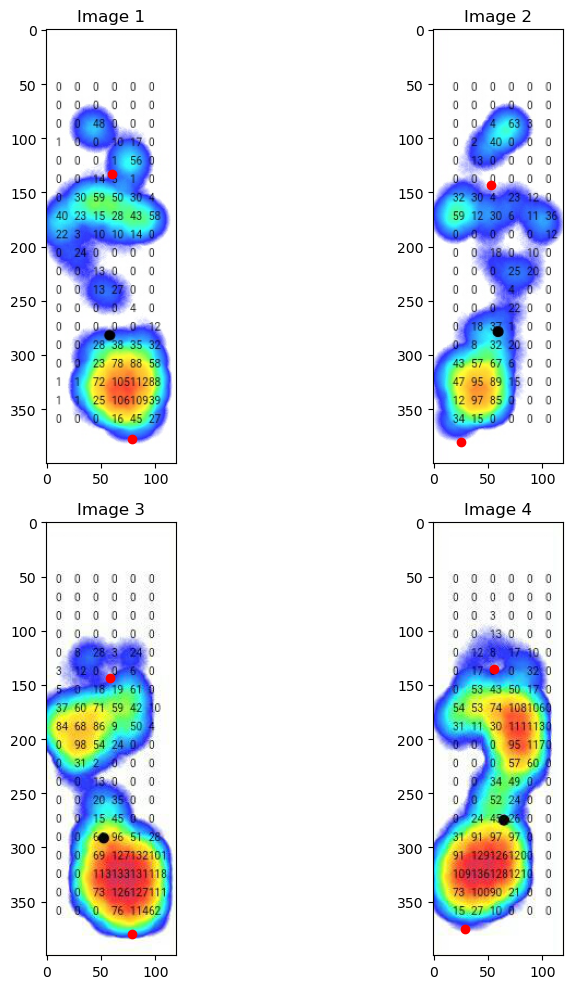

In [44]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    img = df_submission.iloc[i]['images']
    x1, y1, x2, y2 = df_submission.iloc[i][['x1', 'y1', 'x2', 'y2']]
    
    # Load and plot the image
    image = plt.imread(f"./test/images/{img}")
    ax.imshow(image)
    
    # Plot the dots
    ax.plot(x1, y1, 'ro')  # Start point
    ax.plot(x2, y2, 'ro')  # End point
    
    # Set title
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()
